In [1]:
# Parte 1 - creo dataframe
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'      # In futuro considerare periodi bull e bear
DATA_FINE = '2023-12-31'        # Quindi utilizzare sub periodi

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua
df['date']=pd.to_datetime(df['date']) 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(df.columns.tolist())

DataFrame caricato: 1,099,846 righe, 19 colonne
['PERMNO', 'date', 'RET', 'ns', 'me', 'size', 'me_lag', 'ag', 'gp', 'acc', 'bm', 'RF', 'Mkt_RF', 'RET_RF', 'cumret', 'dolvol6', 'ill6', 'volatility', 'beta']


In [2]:
# PARTE 2 - NORMALIZZO CON QUANTILE NORMALIZER

from sklearn.preprocessing import QuantileTransformer

factors_to_normalize = ['ns', 'size', 'ag', 'gp', 'acc', 'bm', 'ill6', 'volatility', 'beta']

# Elimina righe con NaN solo nelle colonne da normalizzare
df_clean = df.dropna(subset=factors_to_normalize)

# Applica Quantile normalization solo ai fattori
scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df_clean.copy()
df_norm[factors_to_normalize] = scaler.fit_transform(df_clean[factors_to_normalize])

print("✅ df normalizzato su fattori:")
df_norm.head()

✅ df normalizzato su fattori:


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.552123,19.90625,0.089730,20.82500,0.429226,0.186763,0.098351,0.751966,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.868132,0.039530,0.100142
1,10001,2000-02-29,0.015385,0.552123,20.21250,0.090958,19.90625,0.429226,0.186763,0.098351,0.746500,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.875944,0.018688,0.100379
2,10001,2000-03-31,-0.015758,0.619632,19.71200,0.088813,20.21250,0.429226,0.186763,0.098351,0.754909,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.864058,0.018764,0.102204
3,10001,2000-04-30,0.011719,0.619632,19.94300,0.089905,19.71200,0.429226,0.186763,0.098351,0.751315,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.822586,0.018568,0.096001
4,10001,2000-05-31,-0.023166,0.619632,19.48100,0.087670,19.94300,0.429226,0.186763,0.098351,0.759141,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.850747,0.018772,0.100983


In [3]:
# Parte 3 - inizializzazione della configurazione

# *** ATTENZIONE *** --> PRIMA MODIFICA, HO MESSO TRUE A WEIGHT

remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': True,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [4]:
# Parte 4 - creazione portafogli single criteria e MJ

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, weighted_portfolios, portfolios_stock_reallocation = compute_factor_strategies(df_norm, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

### COMPUTE VALUE WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=True
MJ_weighted_portfolios, \
mj_voters, \
MJ_weighted_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

weighted_portfolios['wmj'] = MJ_weighted_portfolios['wmj']
portfolios_stock_reallocation['wmj'] = {}
portfolios_stock_reallocation['wmj']['VW_turnover'] = MJ_weighted_portfolios_stock_reallocation['wmj']

'''
OUTPUT: 
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


"\nOUTPUT: \nportfolios = {\n  'ns': DataFrame con port1...port10 costruiti su ns,\n  'beta': ...,\n  'bm': ...,\n  ...\n  'mj': DataFrame con port1...port10 creati con MJ\n}\n"

<Axes: xlabel='medate'>

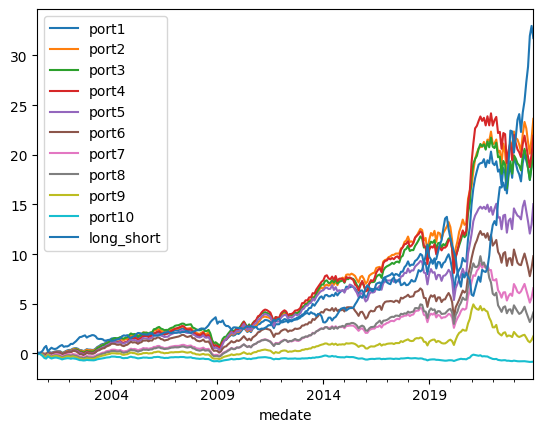

In [5]:
# Parte 5 - plotto
# single criteria

import matplotlib.pyplot as plt

factor='ns'                                     # NS casuale, potremmo usare altro
((1+portfolios[factor]).cumprod()-1).plot()


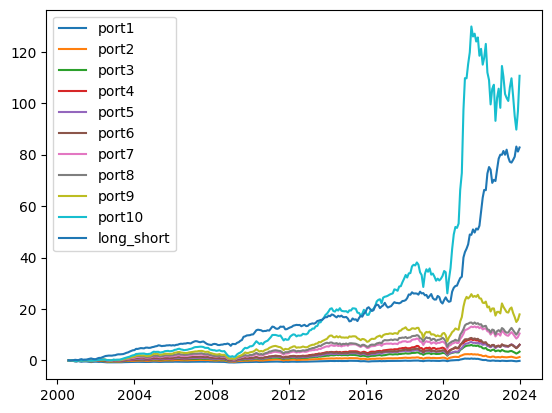

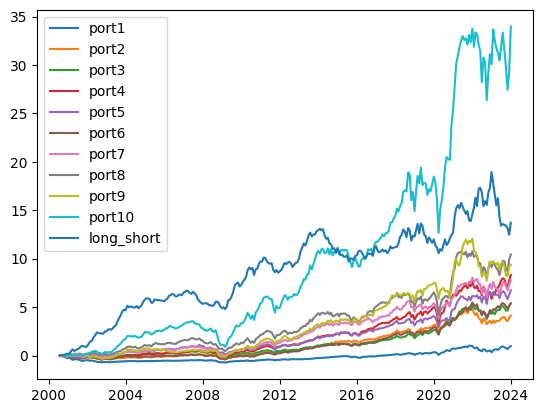

In [6]:
# Plot cumulative returns of EW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# Plot cumulative returns of VW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wmj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

In [7]:
# PARTE 6 - COMPUTE EW-VW MCDM STRATEGY

TOPSIS_portfolios, TOPSIS_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=False)
VIKOR_portfolios, VIKOR_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=False)
PROMETHEE_portfolios, PROMETHEE_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=False)

# inserisco EW mcdm in portfolios e reallocation
portfolios['topsis'] = TOPSIS_portfolios # gia' df
portfolios['vikor'] = VIKOR_portfolios
portfolios['promethee'] = PROMETHEE_portfolios

portfolios_stock_reallocation['topsis'] = TOPSIS_portfolios_stock_reallocation
portfolios_stock_reallocation['vikor'] = VIKOR_portfolios_stock_reallocation
portfolios_stock_reallocation['promethee'] = PROMETHEE_portfolios_stock_reallocation

### COMPUTE VW MCDM STRATEGY
TOPSIS_weighted_portfolios, TOPSIS_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=True)
VIKOR_weighted_portfolios, VIKOR_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=True)
PROMETHEE_weighted_portfolios, PROMETHEE_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=True)

# inserisco VW mcdm in portfolios e reallocation
weighted_portfolios['wtopsis'] = TOPSIS_weighted_portfolios
weighted_portfolios['wvikor'] = VIKOR_weighted_portfolios
weighted_portfolios['wpromethee'] = PROMETHEE_weighted_portfolios

portfolios_stock_reallocation['wtopsis'] = TOPSIS_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wvikor'] = VIKOR_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wpromethee'] = PROMETHEE_weighted_portfolios_stock_reallocation


In [ ]:
'''
from itertools import combinations
from tqdm import tqdm

def rendimento_cumulato(series):
    return (1 + series).prod() - 1

# Tutti i fattori
lista_fattori = factors_df['factors'].tolist()
sign_dict = dict(zip(factors_df['factors'], factors_df['wsigns']))

combinazioni = list(combinations(lista_fattori, 4))

migliore = None
miglior_valore = -float('inf')
miglior_portafoglio = None

print(f"\n🔍 Esploro {len(combinazioni)} combinazioni di 4 fattori...")

for subset in tqdm(combinazioni):
    config_temp = MJ_configuration.copy()
    config_temp['factors'] = list(subset)
    config_temp['default_voters'] = list(subset)
    config_temp['default_signs'] = [sign_dict[f] for f in subset]

    try:
        portfolios_temp, _ = compute_mcdm_rolling_strategy(df_norm, 'promethee', config_temp, weighting=True)
    except Exception as e:
        print(f"Errore su combinazione {subset}: {e}")
        continue

    # Calcolo rendimento cumulato per ogni portafoglio (port1..port10)
    migliori_rendimenti = {
        port: rendimento_cumulato(portfolios_temp[port]) 
        for port in portfolios_temp.columns
    }

    best_port = max(migliori_rendimenti, key=migliori_rendimenti.get)
    best_rend = migliori_rendimenti[best_port]

    if best_rend > miglior_valore:
        migliore = subset
        miglior_valore = best_rend
        miglior_portafoglio = best_port

print("\n🏆 MIGLIOR COMBINAZIONE DI 4 FATTORI (PROMETHEE VW):", migliore)
print(f"➜ Portafoglio {miglior_portafoglio} con rendimento cumulato {miglior_valore:.4f}")
'''


🔍 Esploro 330 combinazioni di 4 fattori...


100%|██████████| 330/330 [1:30:20<00:00, 16.43s/it]


🏆 MIGLIOR COMBINAZIONE DI 4 FATTORI (PROMETHEE VW): ('bm', 'ill6', 'ns', 'size')
➜ Portafoglio port10 con rendimento cumulato 37.0871


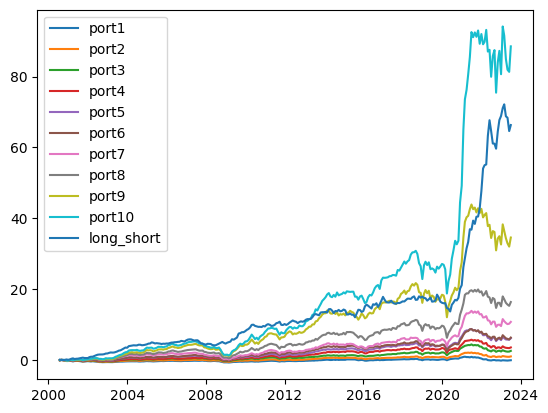

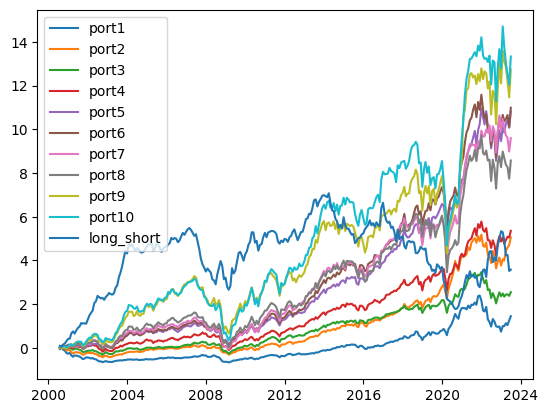


📊 Rendimento cumulato finale TOPSIS EW (11 fattori):
port1        ➜ rendimento cumulato = -0.0597
port2        ➜ rendimento cumulato = 1.0164
port3        ➜ rendimento cumulato = 2.5838
port4        ➜ rendimento cumulato = 3.5537
port5        ➜ rendimento cumulato = 6.1368
port6        ➜ rendimento cumulato = 6.3404
port7        ➜ rendimento cumulato = 10.7661
port8        ➜ rendimento cumulato = 16.3694
port9        ➜ rendimento cumulato = 34.5782
port10       ➜ rendimento cumulato = 88.5451
long_short   ➜ rendimento cumulato = 66.3282

📊 Rendimento cumulato finale TOPSIS VW (11 fattori):
port1        ➜ rendimento cumulato = 1.4469
port2        ➜ rendimento cumulato = 5.0514
port3        ➜ rendimento cumulato = 2.5487
port4        ➜ rendimento cumulato = 5.3522
port5        ➜ rendimento cumulato = 10.8096
port6        ➜ rendimento cumulato = 10.9850
port7        ➜ rendimento cumulato = 9.5972
port8        ➜ rendimento cumulato = 8.5709
port9        ➜ rendimento cumulato = 12.7333
por

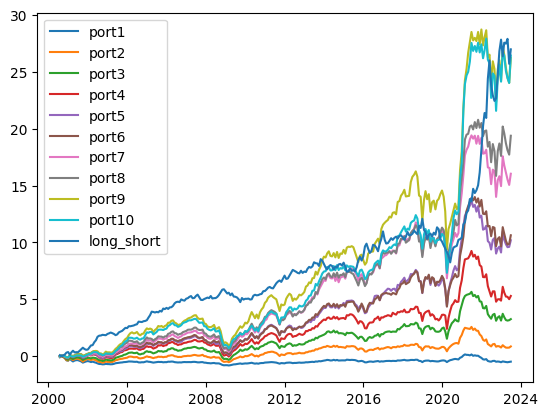

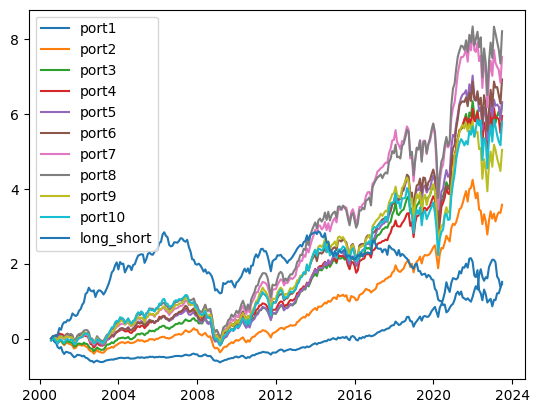


📊 Rendimento cumulato finale VIKOR EW (11 fattori):
port1        ➜ rendimento cumulato = -0.4827
port2        ➜ rendimento cumulato = 0.8546
port3        ➜ rendimento cumulato = 3.2570
port4        ➜ rendimento cumulato = 5.2906
port5        ➜ rendimento cumulato = 10.1890
port6        ➜ rendimento cumulato = 10.6257
port7        ➜ rendimento cumulato = 16.0365
port8        ➜ rendimento cumulato = 19.3770
port9        ➜ rendimento cumulato = 26.2162
port10       ➜ rendimento cumulato = 26.4247
long_short   ➜ rendimento cumulato = 26.9707

📊 Rendimento cumulato finale VIKOR VW (11 fattori):
port1        ➜ rendimento cumulato = 1.5125
port2        ➜ rendimento cumulato = 3.5705
port3        ➜ rendimento cumulato = 6.2715
port4        ➜ rendimento cumulato = 5.9421
port5        ➜ rendimento cumulato = 6.3093
port6        ➜ rendimento cumulato = 6.9176
port7        ➜ rendimento cumulato = 7.5199
port8        ➜ rendimento cumulato = 8.2011
port9        ➜ rendimento cumulato = 5.0359
port10

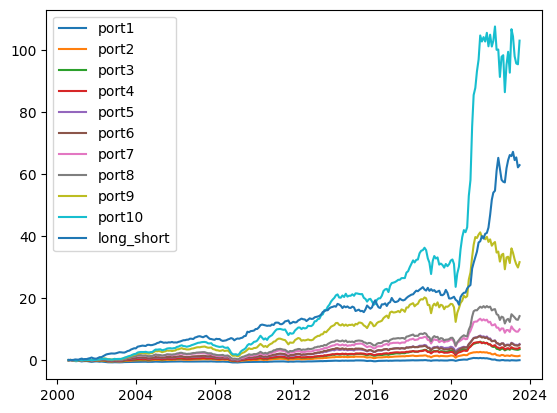

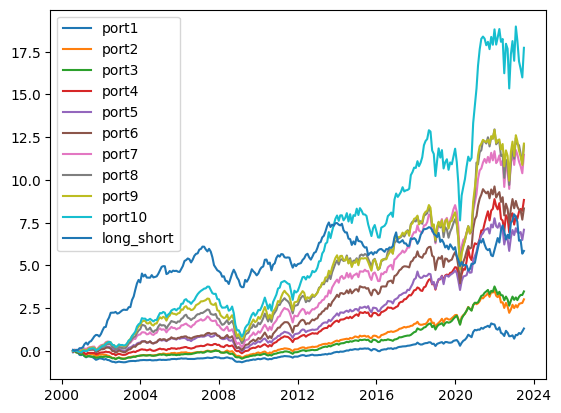


📊 Rendimento cumulato finale PROMETHEE EW (11 fattori):
port1        ➜ rendimento cumulato = -0.0349
port2        ➜ rendimento cumulato = 1.3856
port3        ➜ rendimento cumulato = 3.4825
port4        ➜ rendimento cumulato = 3.9693
port5        ➜ rendimento cumulato = 5.1765
port6        ➜ rendimento cumulato = 4.9776
port7        ➜ rendimento cumulato = 9.9239
port8        ➜ rendimento cumulato = 14.1712
port9        ➜ rendimento cumulato = 31.5756
port10       ➜ rendimento cumulato = 102.9773
long_short   ➜ rendimento cumulato = 62.8453

📊 Rendimento cumulato finale PROMETHEE VW (11 fattori):
port1        ➜ rendimento cumulato = 1.3146
port2        ➜ rendimento cumulato = 3.0211
port3        ➜ rendimento cumulato = 3.4835
port4        ➜ rendimento cumulato = 8.8310
port5        ➜ rendimento cumulato = 7.0895
port6        ➜ rendimento cumulato = 8.3337
port7        ➜ rendimento cumulato = 11.4703
port8        ➜ rendimento cumulato = 12.0216
port9        ➜ rendimento cumulato = 12.12

In [14]:
# PARTE 7 - plot degli mcdm
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['topsis'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wtopsis'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

print("\n📊 Rendimento cumulato finale TOPSIS EW (11 fattori):")
for port in portfolios['topsis'].columns:
    cumulato = (1 + portfolios['topsis'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")
print("\n📊 Rendimento cumulato finale TOPSIS VW (11 fattori):")
for port in weighted_portfolios['wtopsis'].columns:
    cumulato = (1 + weighted_portfolios['wtopsis'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")

# vikor
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['vikor'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wvikor'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

print("\n📊 Rendimento cumulato finale VIKOR EW (11 fattori):")
for port in portfolios['vikor'].columns:
    cumulato = (1 + portfolios['vikor'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")
print("\n📊 Rendimento cumulato finale VIKOR VW (11 fattori):")
for port in weighted_portfolios['wvikor'].columns:
    cumulato = (1 + weighted_portfolios['wvikor'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")

# promethee
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['promethee'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wpromethee'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

print("\n📊 Rendimento cumulato finale PROMETHEE EW (11 fattori):")
for port in portfolios['promethee'].columns:
    cumulato = (1 + portfolios['promethee'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")
print("\n📊 Rendimento cumulato finale PROMETHEE VW (11 fattori):")
for port in weighted_portfolios['wpromethee'].columns:
    cumulato = (1 + weighted_portfolios['wpromethee'][port]).prod() - 1
    print(f"{port:<12} ➜ rendimento cumulato = {cumulato:.4f}")

In [ ]:
from itertools import combinations
from tqdm import tqdm

def rendimento_cumulato(series):
    return (1 + series).prod() - 1

# Dizionari per salvare i migliori risultati
best_subset_returns = {}  # key = metodo, value = pd.Series (port10)
best_subset_names = {}    # key = metodo, value = tuple di fattori

lista_fattori = factors_df['factors'].tolist()
sign_dict = dict(zip(factors_df['factors'], factors_df['wsigns']))
combinazioni = list(combinations(lista_fattori, 4))

print(f"\n🔍 Esploro {len(combinazioni)} combinazioni di 4 fattori per ogni metodo MCDM...\n")

for metodo in ['topsis', 'vikor', 'promethee']:
    miglior_valore = -float('inf')
    miglior_subset = None
    miglior_series = None

    for subset in tqdm(combinazioni, desc=f"{metodo.upper()}"):
        config_temp = MJ_configuration.copy()
        config_temp['factors'] = list(subset)
        config_temp['default_voters'] = list(subset)
        config_temp['default_signs'] = [sign_dict[f] for f in subset]

        try:
            portfolios_temp, _ = compute_mcdm_rolling_strategy(df_norm, metodo, config_temp, weighting=True)
        except Exception as e:
            continue

        try:
            rend = rendimento_cumulato(portfolios_temp['port10'])

            if rend > miglior_valore:
                miglior_valore = rend
                miglior_subset = subset
                miglior_series = portfolios_temp['port10']
        except:
            continue

    best_subset_returns[metodo] = miglior_series
    best_subset_names[metodo] = miglior_subset
    print(f"✅ Migliore subset {metodo.upper()}: {miglior_subset} ➜ rendimento cumulato: {miglior_valore:.4f}\n")

import matplotlib.pyplot as plt

# --- TOPSIS VW ---
plt.figure(figsize=(12, 6))
for port in weighted_portfolios['wtopsis'].columns:
    plt.plot(((1 + weighted_portfolios['wtopsis'][port]).cumprod() - 1), label=port)
plt.plot(((1 + best_subset_returns['topsis']).cumprod() - 1),
         label="TOPSIS (best 4 factors)",
         linestyle='--', linewidth=2.5, color='red')
plt.title("TOPSIS VW – 11 vs 4 fattori")
plt.legend()
plt.grid(True)
plt.show()

# --- VIKOR VW ---
plt.figure(figsize=(12, 6))
for port in weighted_portfolios['wvikor'].columns:
    plt.plot(((1 + weighted_portfolios['wvikor'][port]).cumprod() - 1), label=port)
plt.plot(((1 + best_subset_returns['vikor']).cumprod() - 1),
         label="VIKOR (best 4 factors)",
         linestyle='--', linewidth=2.5, color='red')
plt.title("VIKOR VW – 11 vs 4 fattori")
plt.legend()
plt.grid(True)
plt.show()

# --- PROMETHEE VW ---
plt.figure(figsize=(12, 6))
for port in weighted_portfolios['wpromethee'].columns:
    plt.plot(((1 + weighted_portfolios['wpromethee'][port]).cumprod() - 1), label=port)
plt.plot(((1 + best_subset_returns['promethee']).cumprod() - 1),
         label="PROMETHEE (best 4 factors)",
         linestyle='--', linewidth=2.5, color='red')
plt.title("PROMETHEE VW – 11 vs 4 fattori")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
metodi = list(portfolios.keys())

best_portfolios = {}

print("Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_portfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_portfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_portfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0012
BETA       ➜ rendimento medio mensile = 0.0080
BM         ➜ rendimento medio mensile = 0.0180
CUMRET     ➜ rendimento medio mensile = 0.0051
DOLVOL6    ➜ rendimento medio mensile = 0.0064
GP         ➜ rendimento medio mensile = 0.0128
ILL6       ➜ rendimento medio mensile = 0.0181
NS         ➜ rendimento medio mensile = -0.0016
SIZE       ➜ rendimento medio mensile = 0.0071
VOLATILITY ➜ rendimento medio mensile = 0.0057
ACC        ➜ rendimento medio mensile = 0.0070
MJ         ➜ rendimento medio mensile = 0.0194
TOPSIS     ➜ rendimento medio mensile = 0.0189
VIKOR      ➜ rendimento medio mensile = 0.0139
PROMETHEE  ➜ rendimento medio mensile = 0.0191
**************************************************
WINNER: Il metodo con il miglior PORT10 è: MJ con rendimento medio mensile di 0.0194
**************************************************


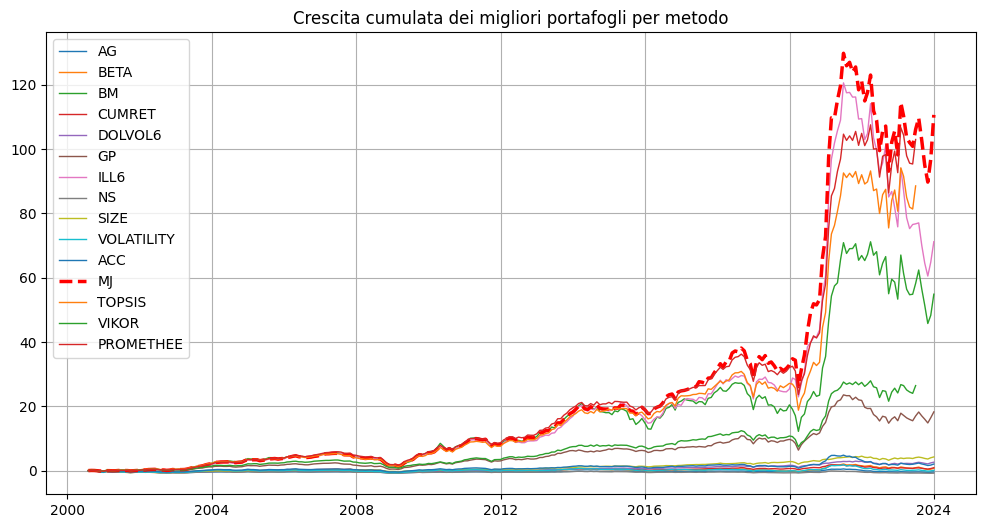

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_portfolios.items():
    serie = portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'mj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()

In [11]:
metodi_w = list(weighted_portfolios.keys())

best_wportfolios = {}

print("Studio dei rendimenti dei portafogli *port10* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_wportfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_wportfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_wportfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 (VW) è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)


Studio dei rendimenti dei portafogli *port10* (VW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0019
BETA       ➜ rendimento medio mensile = 0.0077
BM         ➜ rendimento medio mensile = 0.0104
CUMRET     ➜ rendimento medio mensile = 0.0056
DOLVOL6    ➜ rendimento medio mensile = 0.0061
GP         ➜ rendimento medio mensile = 0.0076
ILL6       ➜ rendimento medio mensile = 0.0124
NS         ➜ rendimento medio mensile = -0.0001
SIZE       ➜ rendimento medio mensile = 0.0062
VOLATILITY ➜ rendimento medio mensile = 0.0040
ACC        ➜ rendimento medio mensile = 0.0042
WMJ        ➜ rendimento medio mensile = 0.0145
WTOPSIS    ➜ rendimento medio mensile = 0.0119
WVIKOR     ➜ rendimento medio mensile = 0.0087
WPROMETHEE ➜ rendimento medio mensile = 0.0123
**************************************************
WINNER: Il metodo con il miglior PORT10 (VW) è: WMJ con rendimento medio mensile di 0.0145
**************************************************


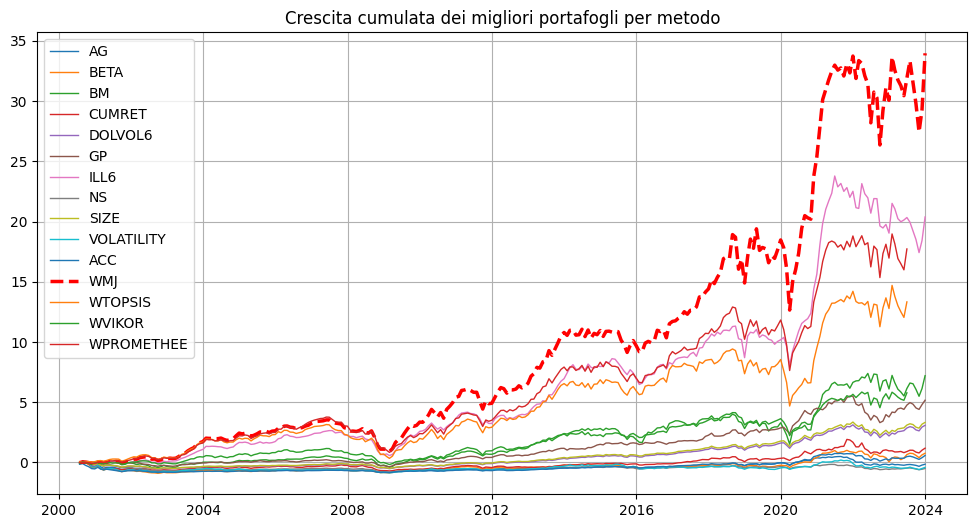

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_wportfolios.items():
    serie = weighted_portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'wmj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()

In [13]:
# UGUALE MA CON LONG SHORT
metodi = list(portfolios.keys())

best_portfolios_LS = {}

print("Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_LS = df_metodo['long_short'].mean()

    best_portfolios_LS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_LS
    }

for metodo, info in best_portfolios_LS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_LS = max(best_portfolios_LS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_LS = migliore_assoluto_LS[0]
rendimento_top_LS = migliore_assoluto_LS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_LS.upper()} con rendimento medio mensile di {rendimento_top_LS:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0115
BETA       ➜ rendimento medio mensile = 0.0012
BM         ➜ rendimento medio mensile = 0.0114
CUMRET     ➜ rendimento medio mensile = -0.0071
DOLVOL6    ➜ rendimento medio mensile = 0.0127
GP         ➜ rendimento medio mensile = 0.0084
ILL6       ➜ rendimento medio mensile = 0.0113
NS         ➜ rendimento medio mensile = 0.0143
SIZE       ➜ rendimento medio mensile = 0.0095
VOLATILITY ➜ rendimento medio mensile = 0.0033
ACC        ➜ rendimento medio mensile = 0.0031
MJ         ➜ rendimento medio mensile = 0.0169
TOPSIS     ➜ rendimento medio mensile = 0.0164
VIKOR      ➜ rendimento medio mensile = 0.0130
PROMETHEE  ➜ rendimento medio mensile = 0.0162
**************************************************
WINNER: Il metodo con il miglior longshort è: MJ con rendimento medio mensile di 0.0169
**************************************************


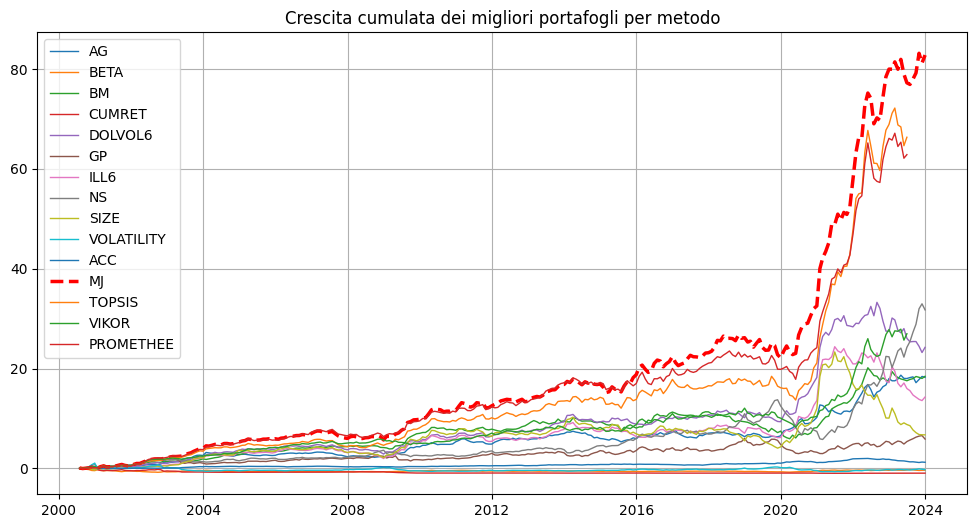

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_portfolios_LS.items():
    serie = portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'mj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()

In [15]:
# UGUALE MA CON LONG SHORT
metodi_w = list(weighted_portfolios.keys())

best_wportfolios_WLS = {}

print("Studio dei rendimenti dei portafogli *long_short* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_WLS = df_metodo['long_short'].mean()

    best_wportfolios_WLS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_WLS
    }

for metodo, info in best_wportfolios_WLS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_WLS = max(best_wportfolios_WLS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_WLS = migliore_assoluto_WLS[0]
rendimento_top_WLS = migliore_assoluto_WLS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_WLS.upper()} con rendimento medio mensile di {rendimento_top_WLS:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *long_short* (VW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0059
BETA       ➜ rendimento medio mensile = 0.0018
BM         ➜ rendimento medio mensile = 0.0057
CUMRET     ➜ rendimento medio mensile = -0.0024
DOLVOL6    ➜ rendimento medio mensile = 0.0071
GP         ➜ rendimento medio mensile = 0.0083
ILL6       ➜ rendimento medio mensile = 0.0063
NS         ➜ rendimento medio mensile = 0.0103
SIZE       ➜ rendimento medio mensile = 0.0057
VOLATILITY ➜ rendimento medio mensile = 0.0034
ACC        ➜ rendimento medio mensile = 0.0026
WMJ        ➜ rendimento medio mensile = 0.0105
WTOPSIS    ➜ rendimento medio mensile = 0.0069
WVIKOR     ➜ rendimento medio mensile = 0.0041
WPROMETHEE ➜ rendimento medio mensile = 0.0078
**************************************************
WINNER: Il metodo con il miglior longshort è: WMJ con rendimento medio mensile di 0.0105
**************************************************


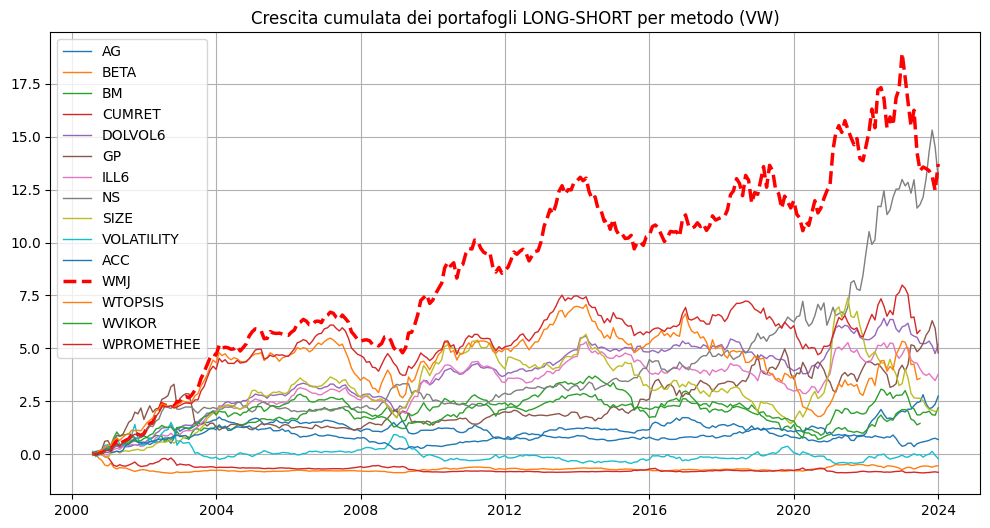

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for metodo, info in best_wportfolios_WLS.items():
    serie = weighted_portfolios[metodo][info['portafoglio']]
    crescita = (1 + serie).cumprod() - 1

    if metodo.lower() == 'wmj':
        plt.plot(crescita, label=metodo.upper(), color='red', linewidth=2.5, linestyle='--')
    else:
        plt.plot(crescita, label=metodo.upper(), linewidth=1)

plt.legend()
plt.title('Crescita cumulata dei portafogli LONG-SHORT per metodo (VW)')
plt.grid(True)
plt.show()


In [17]:
# PARTE 9 - Confronto statistico su sharpe-ratio usando bootstrap

def calculate_sharpe_ratio(returns_series, risk_free_rate=0.0):
    """
    Calcola lo Sharpe Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    """

    mean_return = returns_series.mean() * 12 # Rendimento medio annualizzato
    std_dev = returns_series.std() * np.sqrt(12) # Deviazione standard annualizzata (volatilità)

    annualized_risk_free_rate = risk_free_rate * 12 

    if std_dev == 0:
        return np.nan
    return (mean_return - annualized_risk_free_rate) / std_dev

def compute_portfolio_stats(best_portfolios, portfolios_dict):
    risultati = []

    for metodo, info in best_portfolios.items():
        portafoglio = info['portafoglio']
        serie = portfolios_dict[metodo][portafoglio]

        rendimento_medio = serie.mean()
        volatilita = serie.std()
        sharpe = calculate_sharpe_ratio(serie)

        # Calcolo drawdown
        cumulative = (1 + serie).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = drawdown.min()

        risultati.append({
            'Metodo': metodo,
            'Portafoglio': portafoglio,
            'Rendimento medio': rendimento_medio,
            'Volatilità': volatilita,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_drawdown
        })

    return pd.DataFrame(risultati)

stats_ew = compute_portfolio_stats(best_portfolios, portfolios)
stats_vw = compute_portfolio_stats(best_wportfolios, weighted_portfolios)


print("Statistiche portafogli Equal Weighted (EW):")
print(stats_ew.round(4))

print("\nStatistiche portafogli Value Weighted (VW):")
print(stats_vw.round(4))


def bootstrap_sharpe_comparison(returns1, returns2, num_bootstrap_samples=1000, risk_free_rate=0.0): # “In quante simulazioni lo Sharpe di WMJ è maggiore di quello dell'altro?”
    """
    Confronta gli Sharpe Ratio di due serie di rendimenti usando il bootstrapping.
    Restituisce la proporzione di volte che Sharpe1 > Sharpe2 (p-value unilaterale).
    """
    sharpes_diff = []
    n1 = len(returns1)
    n2 = len(returns2)

    for _ in range(num_bootstrap_samples):
        # Campionamento con re-inserimento
        sample1 = np.random.choice(returns1, size=n1, replace=True)
        sample2 = np.random.choice(returns2, size=n2, replace=True)

        sharpe1 = calculate_sharpe_ratio(pd.Series(sample1), risk_free_rate)
        sharpe2 = calculate_sharpe_ratio(pd.Series(sample2), risk_free_rate)

        if not np.isnan(sharpe1) and not np.isnan(sharpe2):
            sharpes_diff.append(sharpe1 - sharpe2)

    if not sharpes_diff: # Nessun confronto possibile se entrambi NaN sempre
        return np.nan

    # Calcola il p-value unilaterale per H0: Sharpe1 <= Sharpe2 vs H1: Sharpe1 > Sharpe2
    # Cioè, quante volte Sharpe1-Sharpe2 è minore o uguale a zero
    p_value_one_sided = np.sum(np.array(sharpes_diff) <= 0) / len(sharpes_diff)

    return p_value_one_sided

# --- Applicazione ---
print("\n--- Confronto Statistico degli Sharpe Ratio (WMJ vs Altri VW) ---")

# Tasso risk-free mensile (assumo 0 per semplicità ) --> giustificare durante tesi
RISK_FREE_MONTHLY = 0.0 

wmj_port_name = best_wportfolios['wmj']['portafoglio']
wmj_returns_series = weighted_portfolios['wmj'][wmj_port_name]

for metodo in [k for k in weighted_portfolios.keys() if k != 'wmj']:
    other_port_name = best_wportfolios[metodo]['portafoglio']
    other_returns_series = weighted_portfolios[metodo][other_port_name]

    min_len = min(len(wmj_returns_series), len(other_returns_series))
    wmj_sample_returns = wmj_returns_series.iloc[:min_len]
    other_sample_returns = other_returns_series.iloc[:min_len]

    # Chiamo la funzione
    p_value = bootstrap_sharpe_comparison(wmj_sample_returns, other_sample_returns, num_bootstrap_samples=2000, risk_free_rate=RISK_FREE_MONTHLY)

    # Interpretazione del p-value
    alpha = 0.05 # Livello di significatività

    print(f"\nConfronto WMJ vs {metodo.upper()}:")
    if p_value < alpha:
        print(f"La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di {metodo.upper()} (p-value = {p_value:.4f})")
    else:
        print(f"Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra WMJ e {metodo.upper()} (p-value = {p_value:.4f})")


# Dai risultati, wmj è tra i portafogli più efficienti (ottimo trade-off rendimento/rischio)

Statistiche portafogli Equal Weighted (EW):
        Metodo Portafoglio  Rendimento medio  Volatilità  Sharpe Ratio  \
0           ag      port10            0.0012      0.0834        0.0519   
1         beta      port10            0.0080      0.1131        0.2448   
2           bm      port10            0.0180      0.0868        0.7180   
3       cumret      port10            0.0051      0.0748        0.2346   
4      dolvol6      port10            0.0064      0.0597        0.3683   
5           gp      port10            0.0128      0.0674        0.6564   
6         ill6      port10            0.0181      0.0776        0.8103   
7           ns      port10           -0.0016      0.0957       -0.0574   
8         size      port10            0.0071      0.0497        0.4976   
9   volatility      port10            0.0057      0.1067        0.1842   
10         acc      port10            0.0070      0.0798        0.3057   
11          mj      port10            0.0194      0.0724        0.92

In [25]:
from scipy.stats import ttest_rel  # t-test per campioni appaiati

metodi_vw = [k for k in weighted_portfolios.keys() if k != 'wmj']
wmj_port = best_wportfolios['wmj']['portafoglio']  # dovrebbe essere 'port10'
wmj_returns = weighted_portfolios['wmj'][wmj_port]

metodi_rilevanti = []
metodi_irrilevanti = []

print("\n--- Confronto Statistico: t-test tra WMJ e altri metodi (port10 VW) ---")

for metodo in metodi_vw:
    portafoglio = best_wportfolios[metodo]['portafoglio']  # dovrebbe essere 'port10'
    altri_returns = weighted_portfolios[metodo][portafoglio]

    # Allinea lunghezze
    min_len = min(len(wmj_returns), len(altri_returns))
    wmj_sample = wmj_returns.iloc[:min_len]
    altri_sample = altri_returns.iloc[:min_len]

    # t-test a due code per confronto di medie
    stat, p_value = ttest_rel(wmj_sample, altri_sample)

    if p_value < 0.05:
        print(f"\nWMJ vs {metodo.upper()}")
        print(f"t-statistic = {stat:.4f}, p-value = {p_value:.4f}")
        metodi_rilevanti.append(metodo.upper())
    else:
        metodi_irrilevanti.append(metodo.upper())

print(f"\n✅ I metodi {metodi_rilevanti} HANNO una differenza statisticamente significativa nella media dei rendimenti rispetto a WMJ.")
print(f"➖ I metodi {metodi_irrilevanti} NON hanno una differenza statisticamente significativa rispetto a WMJ.")



--- Confronto Statistico: t-test tra WMJ e altri metodi (port10 VW) ---

WMJ vs AG
t-statistic = 4.6495, p-value = 0.0000

WMJ vs CUMRET
t-statistic = 2.8281, p-value = 0.0050

WMJ vs DOLVOL6
t-statistic = 3.6686, p-value = 0.0003

WMJ vs GP
t-statistic = 2.9803, p-value = 0.0031

WMJ vs NS
t-statistic = 5.9711, p-value = 0.0000

WMJ vs SIZE
t-statistic = 3.5947, p-value = 0.0004

WMJ vs VOLATILITY
t-statistic = 2.5182, p-value = 0.0124

WMJ vs ACC
t-statistic = 3.8809, p-value = 0.0001

WMJ vs WVIKOR
t-statistic = 3.3116, p-value = 0.0011

WMJ vs WPROMETHEE
t-statistic = 1.9975, p-value = 0.0468

✅ I metodi ['AG', 'CUMRET', 'DOLVOL6', 'GP', 'NS', 'SIZE', 'VOLATILITY', 'ACC', 'WVIKOR', 'WPROMETHEE'] HANNO una differenza statisticamente significativa nella media dei rendimenti rispetto a WMJ.
➖ I metodi ['BETA', 'BM', 'ILL6', 'WTOPSIS'] NON hanno una differenza statisticamente significativa rispetto a WMJ.


In [26]:
def calculate_sortino_ratio(returns_series, risk_free_rate=RISK_FREE_MONTHLY):
    """
    Calcola il Sortino Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    """
    # Rendimenti sotto il target (risk_free_rate mensile)
    excess_returns = returns_series - risk_free_rate
    negative_excess_returns = excess_returns[excess_returns < 0]
    
    downside_deviation = negative_excess_returns.std() * np.sqrt(12) # Annualizza
    
    mean_return = returns_series.mean() * 12 # Annualizza
    annualized_risk_free_rate = risk_free_rate * 12

    if downside_deviation == 0 or np.isnan(downside_deviation): # Gestisci il caso di deviazione standard zero o NaN
        return np.nan
    return (mean_return - annualized_risk_free_rate) / downside_deviation

def find_best_portfolio_by_metric(portfolios_dict, metric_name, metric_calc_func=None, higher_is_better=True):
    best_portfolios_by_metric = {}

    print(f"\n--- Studio dei portafogli VW per: {metric_name.replace('_', ' ').upper()} (solo port10) ---")
    for metodo, df_metodo in portfolios_dict.items():
        metric_values = {}

        if 'port10' not in df_metodo.columns:
            print(f"⚠️ {metodo.upper()} non ha port10 — salto")
            continue

        series = df_metodo['port10']

        if metric_name == 'rendimento_cumulato':
            value = (1 + series).prod() - 1
        elif metric_calc_func:
            value = metric_calc_func(series)
        else:
            raise ValueError(f"La funzione di calcolo per '{metric_name}' non è specificata.")
        
        metric_values['port10'] = value

        best_value = value
        best_portfolios_by_metric[metodo] = {
            'portafoglio': 'port10',
            metric_name: best_value
        }

    for metodo, info in best_portfolios_by_metric.items():
        print(f"{metodo.upper():<10} ➜ port10 con {metric_name.replace('_', ' ')} {info[metric_name]:.4f}")

    # Trova il miglior metodo tra tutti (sempre usando port10)
    if higher_is_better:
        migliore_assoluto = max(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])
    else:
        migliore_assoluto = min(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])

    metodo_top = migliore_assoluto[0]
    portafoglio_top = migliore_assoluto[1]['portafoglio']
    value_top = migliore_assoluto[1][metric_name]
    
    print("*" * 50)
    print(f"WINNER: Il miglior metodo VW per {metric_name.replace('_', ' ').upper()} è: {metodo_top.upper()} ➜ port10 con valore {value_top:.4f}")
    print("*" * 50)
    
    return best_portfolios_by_metric


# --- Esecuzione ---

# 1. Miglior portafoglio per Rendimento Cumulato
best_wportfolios_cumulative = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'rendimento_cumulato', 
    higher_is_better=True
)

# 2. Miglior portafoglio per Sharpe Ratio
best_wportfolios_sharpe = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'sharpe_ratio', 
    metric_calc_func=calculate_sharpe_ratio, 
    higher_is_better=True
)

# 3. Miglior portafoglio per Sortino Ratio
best_wportfolios_sortino = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'sortino_ratio', 
    metric_calc_func=calculate_sortino_ratio, 
    higher_is_better=True
)

# Tabella riassuntiva finale:
summary_data = []
for method in weighted_portfolios.keys():
    row = {'Metodo': method.upper()}
    
    if method in best_wportfolios_cumulative:
        row['Port. Cum. Ret.'] = best_wportfolios_cumulative[method]['portafoglio']
        row['Max Cum. Ret.'] = best_wportfolios_cumulative[method]['rendimento_cumulato']
    
    if method in best_wportfolios_sharpe:
        row['Port. Sharpe'] = best_wportfolios_sharpe[method]['portafoglio']
        row['Max Sharpe'] = best_wportfolios_sharpe[method]['sharpe_ratio']
        
    if method in best_wportfolios_sortino:
        row['Port. Sortino'] = best_wportfolios_sortino[method]['portafoglio']
        row['Max Sortino'] = best_wportfolios_sortino[method]['sortino_ratio']
        
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n--- Riepilogo dei Migliori Portafogli per Metrica (VW) ---")
print(summary_df.round(4).to_string()) # to_string() per visualizzare tutte le colonne


--- Studio dei portafogli VW per: RENDIMENTO CUMULATO (solo port10) ---
AG         ➜ port10 con rendimento cumulato -0.1486
BETA       ➜ port10 con rendimento cumulato 0.7639
BM         ➜ port10 con rendimento cumulato 7.2033
CUMRET     ➜ port10 con rendimento cumulato 1.1851
DOLVOL6    ➜ port10 con rendimento cumulato 3.0822
GP         ➜ port10 con rendimento cumulato 5.1674
ILL6       ➜ port10 con rendimento cumulato 20.3835
NS         ➜ port10 con rendimento cumulato -0.5004
SIZE       ➜ port10 con rendimento cumulato 3.3273
VOLATILITY ➜ port10 con rendimento cumulato -0.4084
ACC        ➜ port10 con rendimento cumulato 0.5783
WMJ        ➜ port10 con rendimento cumulato 33.9757
WTOPSIS    ➜ port10 con rendimento cumulato 13.3322
WVIKOR     ➜ port10 con rendimento cumulato 5.7840
WPROMETHEE ➜ port10 con rendimento cumulato 17.7269
**************************************************
WINNER: Il miglior metodo VW per RENDIMENTO CUMULATO è: WMJ ➜ port10 con valore 33.9757
****************

In [27]:
# Parte 11 - Simulazione costi di transazione

# Rendimento lordo mensile del port10 WMJ
rendimento_lordo_mensile = best_wportfolios['wmj']['rendimento_medio']

# Turnover medio del portafoglio port10 WMJ (Value Weighted)
df_turnover = portfolios_stock_reallocation['wmj']
df_vw = df_turnover['VW_turnover']
turnover_medio = df_vw[df_vw['portfolio'] == 10.0]['VW_turnover'].values[0]

# Costo per transazione (es. 0.2%)
costo_transazione = 0.002

# Impatto medio mensile dei costi di transazione
impatto_costo = turnover_medio * costo_transazione

# Rendimento netto stimato
rendimento_netto_mensile = rendimento_lordo_mensile - impatto_costo

print(f"Turnover medio mensile stimato: {turnover_medio:.4f}")
print(f"Rendimento lordo WMJ: {rendimento_lordo_mensile:.4f}")
print(f"Rendimento netto stimato WMJ dopo costi: {rendimento_netto_mensile:.4f}")
print(f"Penalizzazione dovuta a costi: {impatto_costo:.4f}")


Turnover medio mensile stimato: 0.3452
Rendimento lordo WMJ: 0.0145
Rendimento netto stimato WMJ dopo costi: 0.0139
Penalizzazione dovuta a costi: 0.0007



DataFrame normalizzato:
             Rendimento medio  Volatilità  Sharpe Ratio  Max Drawdown
Metodo                                                              
dolvol6             0.000000    1.000000      0.000000      0.000000
wmj                 1.000000    0.254003      1.000000      0.223442
wtopsis             0.685244    0.000000      0.458743      1.000000
wpromethee          0.736619    0.452295      0.786924      0.495059


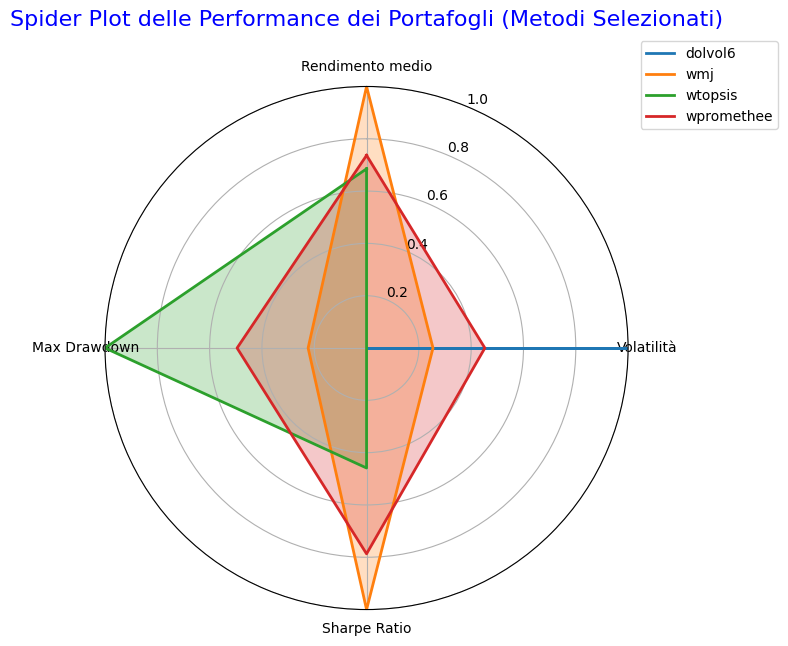

In [28]:
# Parte 12- spider plot che non e' neanche sto gran vedere

import numpy as np
import matplotlib.pyplot as plt

def plot_spider(df_stats, metodi_spider_plot):
    df_filtered_stats = df_stats[df_stats['Metodo'].isin(metodi_spider_plot)].set_index('Metodo')

    categories = ['Rendimento medio', 'Volatilità', 'Sharpe Ratio', 'Max Drawdown']

    normalized_df = pd.DataFrame(index=df_filtered_stats.index, columns=categories)

    for col in categories:
        if col in ['Rendimento medio', 'Sharpe Ratio']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            normalized_df[col] = (df_filtered_stats[col] - min_val) / (max_val - min_val) if (max_val - min_val) != 0 else 0
        elif col in ['Volatilità', 'Max Drawdown']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            if (max_val - min_val) != 0:
                normalized_df[col] = 1 - (df_filtered_stats[col] - min_val) / (max_val - min_val)
            else:
                normalized_df[col] = 0

    normalized_df = normalized_df.fillna(0).clip(0, 1)
    print("\nDataFrame normalizzato:\n", normalized_df)

    labels = np.array(categories)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, row in normalized_df.iterrows():
        values = row.tolist()
        values += values[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
    ax.set_ylim(0, 1)

    plt.title('Spider Plot delle Performance dei Portafogli (Metodi Selezionati)', size=16, color='blue', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

metodi_spider_plot = ['dolvol6', 'wmj', 'wtopsis', 'vikor', 'wpromethee']
plot_spider(stats_vw, metodi_spider_plot )

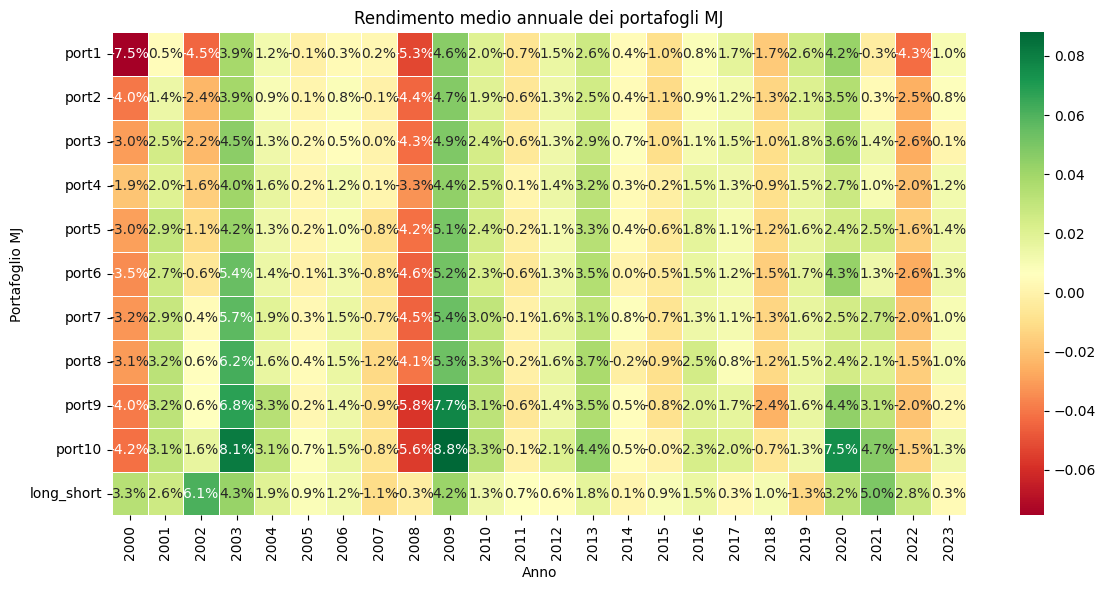

In [29]:
import seaborn as sns

df_mj = portfolios['mj'].copy()
df_mj.index = pd.to_datetime(df_mj.index)

mj_annual_returns = df_mj.resample('Y').mean()
mj_annual_returns.index = mj_annual_returns.index.year

# 4. Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mj_annual_returns.T, cmap="RdYlGn", annot=True, fmt=".1%", linewidths=.5)
plt.title("Rendimento medio annuale dei portafogli MJ")
plt.xlabel("Anno")
plt.ylabel("Portafoglio MJ")
plt.tight_layout()
plt.show()


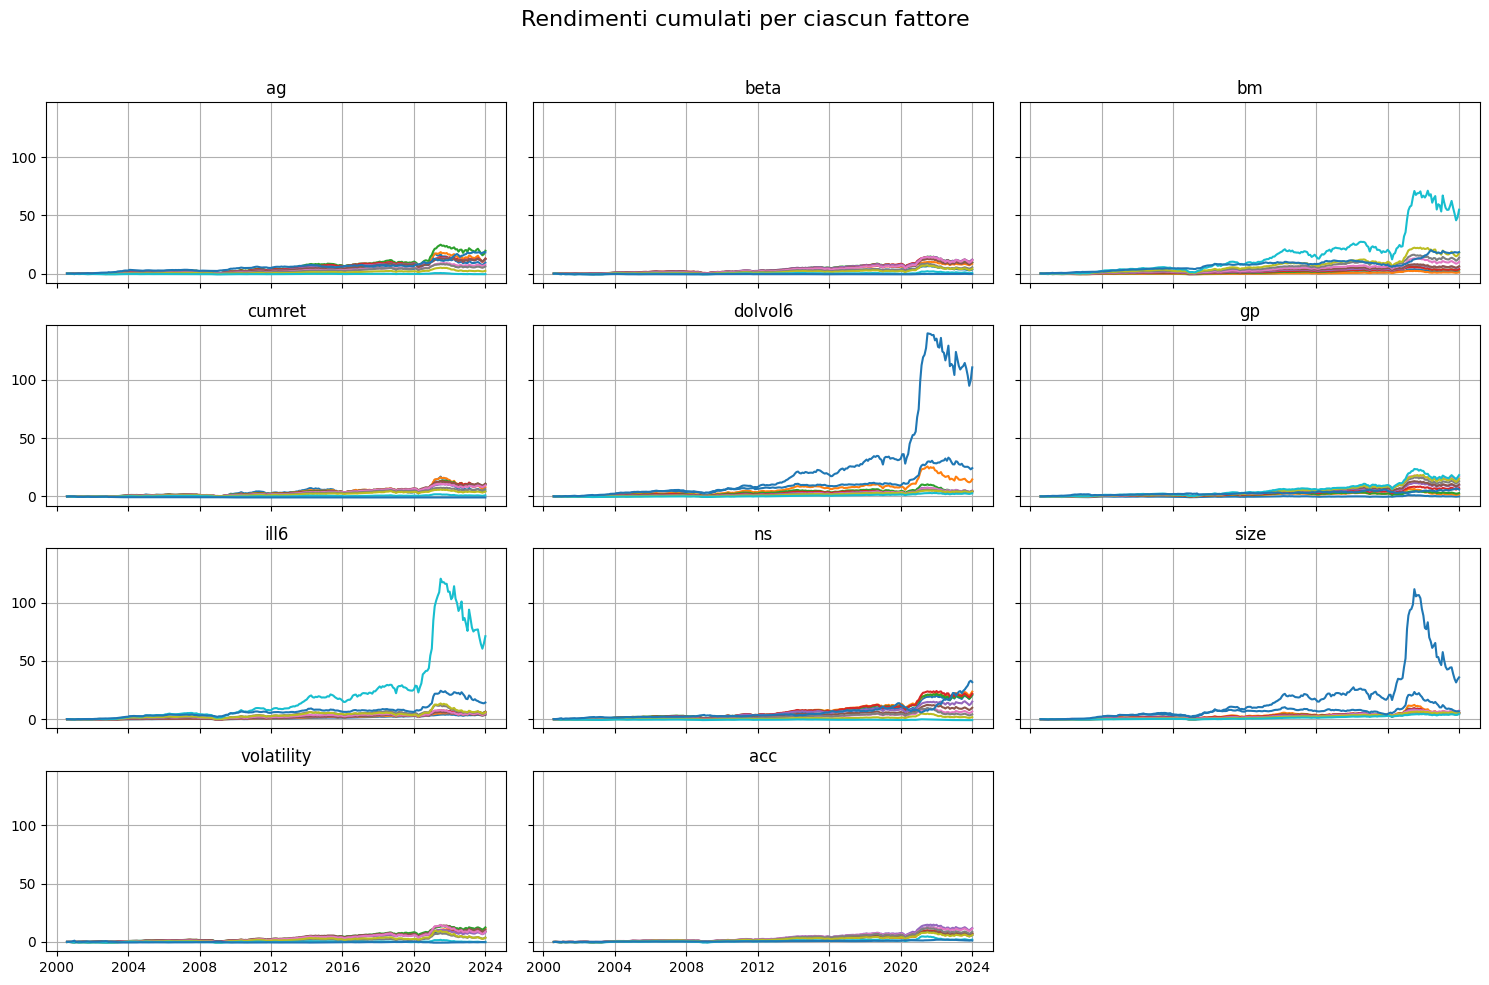

In [30]:
# Setup griglia subplot: es. 4 righe x 3 colonne
n = len(factors)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, factor in enumerate(factors):
    ax = axes[i]
    cumulative_returns = (1 + portfolios[factor]).cumprod() - 1
    ax.plot(cumulative_returns, label=factor)
    ax.set_title(factor)
    ax.grid(True)

# Nascondi assi vuoti se i subplot superano il numero di fattori
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Rendimenti cumulati per ciascun fattore', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # spazio per il titolo
plt.show()


In [24]:
# a-jensen + modificare confronti (1vs 10, ls vs ls)
#ttest-rel al posto di wilcoxon
